In [17]:
import sys
import os
import time
import csv
import logging
import pandas as pd
from datetime import date
import datetime
# import click
import numpy as np
# import logging
import matplotlib.pyplot as plt
import multiprocess as mp
# from IsingLattice import IsingLattice as IsingLattice_c
from sys import exit, argv
# from pandas import DataFrame
# from tqdm import tqdm #fancy progress bar generator
# from ising_c import run_ising #import run_ising function from ising.pyb

# conditionally import python and C++ version of IsingLattice
has_cpp = False
from IsingLattice_python import IsingLattice as IsingLattice_py
if os.path.isfile('ising_lattice_lib.so'):
    has_cpp = True
    from IsingLattice_cpp    import IsingLattice as IsingLattice_cpp

In [18]:
## main program
def make_B_generator(inp, t_final=None):
    """Return a generator that makes values of B (magetic field in each step)
    note: you *should* play with this function
    
    default implementation: always return 0
    """
    for val in range(inp['n_steps']):
        yield inp['B']

def make_T_generator(inp, t_final):
    """Return a generator that makes values of T (temperature in each step)
    note: you *should* play with this function
    
    default implementation: 
        start at T=t_top, and linearly decrease temperature to t_final
        hold at t_final for n_burnin
        hold at t_final for n_analyze
    """
    n_slope = inp['n_steps'] - inp['n_burnin'] - inp['n_analyze']
    if n_slope < 0:
        print('fatal error: n_steps - n_burnin - n_slope < 0')
        print('terminating program')
        exit(2)

    # get linearly decreasing values from t_top to t_final
    for val in np.linspace(start=inp['t_top'], stop=t_final, num=n_slope):
        yield val

    for val in range(inp['n_burnin']):
        yield t_final

    for val in range(inp['n_analyze']):
        yield t_final

In [24]:

def set_input(cmd_line_args):
    """Parse command-line parameters into an input dictionary.
    use default values

    input:   sys.argv
             use syntax of keyword:value on command line
    return:  dict[key] = value
    note:    Any value which can be turned into a number will be a float 
             if it has a '.', otherwise it will be a float.

    """

    inp = dict()
    inp['t_min']      = 2    # minimum temperature
    inp['t_max']      = 3    # maximum temperature
    inp['t_step']     = 0.02    # step size from min to max temperature
    inp['t_top']      = 4.0    # start temperature (arbitrary; feel free to change)
    inp['N']          = 100     # sqrt(lattice size) (i.e. lattice = N^2 points
    inp['n_steps']    = 100000  # number of lattice steps in simulation
    inp['n_burnin']   = 50000   # optional parameter, used as naive default
    inp['n_analyze']  = 30000   # number of lattice steps at end of simulation calculated for averages and std.dev.
    # inp['J']          = 1.0    # **great** default value -- spin-spin interaction strength
    inp['B']          = 0.0    # magnetic field strength
    inp['flip_perc']  = 0.1    # ratio of sites examined to flip in each step
    # maindir=os.path.join(os.getcwd(),date.today().strftime("%b-%d-%Y"))
    # if not os.path.isdir(maindir):
    #     os.makedirs(os.path.join(maindir))
    # i=0
    # while os.path.isdir()
    inp['dir_out']    = 'data' # output directory for file output
    inp['plots']      = False  # whether or not plots are generated
                               
    inp['print_inp']  = False  # temperature option
    inp['use_cpp']    = True   # use 1 for True and 0 for False

    inp['date_output'] = True
    inp['file_prefix'] = ''
    inp['multiprocess'] = True
    inp['skip_prog_print'] = False

    for x in cmd_line_args[1:]:
        if ':' in x:
            try:
                key, val = x.split(':')
                try:
                    if '.' in val:
                        inp[key] = float(val)
                        print('%-20s'%('inp["%s"]'%key),'set to float  ',inp[key])
                    elif val.lower() == 'false' or val.lower() == 'f':
                        inp[key] = False
                    elif val.lower() == 'true' or val.lower() == 't':
                        inp[key] = True
                    else:
                        inp[key] = int(val)
                        print('%-20s'%('inp["%s"]'%key),'set to int    ',inp[key])
                except:
                    inp[key] = val
                    print('%-20s'%('inp["%s"]'%key),'set to string ',inp[key])
            except:
                print('warning: input "%s" not added to arguments'%x)
        else:
            print('ignoring command line input: %s'%x)

    if inp['print_inp']:
        print('Printed list of input keys:')
        for key in sorted(inp.keys()):
            print('%-20s'%key,' ',inp[key])
    return inp

In [20]:

class check_progress(object):
    """A class that will print a simple status bar of percentage of work done"""
    def __init__(self, inp, T, skip_progress=False):
        self.skip_print = skip_progress
        if self.skip_print:
            return

        self.start_time = time.time()
        self.n_steps = inp['n_steps']
        self.n_check = 1000
        if 'check_per_steps' in inp:
            self.n_check = inp['check_per_steps']
        self.fmt_print = ('%ix%i (T=%.2f) steps: %%7i/%7i, %%5.1f%%%%  '
                'run time: %%8s  est.time-to-go: %%8s'%
                (inp['N'], inp['N'], T, self.n_steps))
        self.n_called = -1 # will progress untill n_called = n_steps
        self.check()
        # print(self.fmt_print)

        # if False:
        #     print('%ix%i IsingLattice. Finished %10i / %10i steps (%4.1f%%). '
        #         'Started '+str(time.strftime('%m-%d %H:%M:%S')))
            # dir_out += str(time.strftime("_%Y%m%d-%H%M%S"))
    def check(self, final=False):
        if self.skip_print:
            return

        self.n_called += 1

        if not self.n_called % 1000 == 0 and not final:
            return
        ratio = float(self.n_called) / self.n_steps
        if ratio == 0:
            time_pass_str = '00:00:00'
            est_str = 'n/a'
        else:
            time_pass = time.time() - self.start_time 
            time_pass_str = time.strftime('%H:%M:%S', time.gmtime(time_pass));
            est_time  = (1-ratio)*time_pass/ratio
            # print('est_time ', est_time)
            est_str = time.strftime('%H:%M:%S', time.gmtime(est_time))
        if final:
            print(self.fmt_print%(self.n_called, ratio*100., time_pass_str, 'done!'))
        else:
            print(self.fmt_print%(self.n_called, ratio*100., time_pass_str, est_str), end='\r')

        
# def check_progress(inp):
#     '''Print the progress of the plot'''
#     pass


In [21]:

def run_ising_lattice(inp, T_final, skip_print=False):
    '''Run a 2-D Ising model on a lattice.
    Return three objects (each a numpy.array, which you can treat
    as identical to a numpy.array)
        M_avg:       the average magnetization of each site for each n_analyze step
        E_avg:       '.........' energy        '..................................'
        correlation: an (N/2-1) array of the correlation function values at the final data frame

        Note that this will use the generators from functions:
        (1) make_T_generator
        (2) make_B_generator
    '''

    time_start = time.time()

    lattice = None
    if inp['use_cpp'] and has_cpp:
        lattice = IsingLattice_cpp(inp['N'], inp['flip_perc'])
    elif inp['use_cpp'] and not has_cpp:
        print('Warning: although use_cpp is set to 1, '
        ' the shared library IsingLattice.so is not present.\n '
        ' Therefore, the python implementation of Ising will be used.')
        lattice = IsingLattice_py(inp['N'],inp['flip_perc'])
    else:
        lattice = IsingLattice_py(inp['N'],inp['flip_perc'])

    # Make the run loop
    try: # try loop that can be interrupted by the user
        #first loop through all steps up to n_analyze
        T_generator = make_T_generator(inp, T_final)
        B_generator = make_B_generator(inp, T_final)
        n_prior = inp['n_steps'] - inp['n_analyze']

        progress = check_progress(inp, T_final, skip_print)

        for T, B, step in zip(T_generator, B_generator, range(n_prior)):
            lattice.step(T,B)
            progress.check()

        # loop through the analyze section of generators
        E_avg = []
        M_avg = []
        for T, B, step in zip(T_generator, B_generator, range(inp['n_analyze'])):
            lattice.step(T,B)
            E_avg.append(lattice.get_E())
            M_avg.append(lattice.get_M())
            progress.check()
        progress.check(True)
        spin_correlation = np.array(lattice.calc_auto_correlation())

        lattice.free_memory()
        return (
            np.array(E_avg),
            np.array(M_avg),
            np.array(spin_correlation)
        )

    except KeyboardInterrupt:
        try:
            lattice.free_memory()
        except:
            pass
        print("\n\nProgram terminated by keyboard. Good Bye!")
        sys.exit()

In [22]:

def plot_graphs(data): #T,E_mean,E_std,M_mean,M_std): #plot graphs at end
    dat = np.array(data)
    # print('data: ', dat)
    # print('x: ', dat[:,1])
    # x = dat[:,1][0]
    # print('xlist: ', x)

    plt.figure(1)
    # plt.ylim(0,1)
    plt.errorbar(dat[:,0], dat[:,1], yerr=dat[:,2], fmt='o')
    plt.xlabel('Temperature')
    plt.ylabel('Average Site Energy')
    plt.figure(2)
    plt.errorbar(dat[:,0], np.absolute(dat[:,3]), yerr=dat[:,4], uplims=True, lolims=True,fmt='o')
    plt.xlabel('Temperature')
    plt.ylabel('Aveage Site Magnetization')
    plt.show()

def get_filenames(inp): #make data folder if doesn't exist, then specify filename
    '''Generate the output file names for the EM (energy and megnetism) and SC (spin correlation) files'''
    try:
        dir_out = inp['dir_out']
        prefix  = inp['file_prefix']
        if inp['date_output']:
            dir_out += str(time.strftime("_%Y%m%d-%H%M%S"))

        if not os.path.isdir(dir_out):
            os.makedirs(dir_out)

        # file name = [file_prefix]##_EM_v#.csv if only one temperature (example: runA_4.20_EM_v0.csv)
        #             [file_prefix]##T##_EM_v#.csv if there are two temperatures (example: runA_4.2T5.3_EM_v0.csv) 
        # the other file name is identical, but with "SC" (for spin correlation)) instead of EM
        if inp['t_max'] <= inp['t_min']:
            t_name = '%.2f'%inp['t_min']
        else:
            t_name = '%.2fT%.2f'%(inp['t_min'],inp['t_max'])

        # print('%s%s_SC_v%i.csv'%(prefix,t_name,v))
        v = 0
        while (os.path.isfile( os.path.join(dir_out, '%s%s_EM_v%i.csv'%(prefix,t_name,v))) or
               os.path.isfile( os.path.join(dir_out, '%s%s_SC_v%i.csv'%(prefix,t_name,v)))):
            v += 1

        return ( os.path.join(dir_out, '%s%s_EM_v%i.csv'%(prefix,t_name,v)),
                 os.path.join(dir_out, '%s%s_SC_v%i.csv'%(prefix,t_name,v)) )

    except:
        print ('fatal: Failed to make output file names')
        sys.exit()

def print_results(inp, data, corr):
    data_filename, corr_filename = get_filenames(inp)
    with open(data_filename,'w') as f_out:
        writer = csv.writer(f_out, delimiter=',', lineterminator='\n')
        writer.writerow(['N', 'n_steps', 'n_analyze', 'flip_perc'])
        writer.writerow([inp['N'], inp['n_steps'], inp['n_analyze'], inp['flip_perc']])
        writer.writerow([])
        writer.writerow(['Temp','E_mean','E_std','M_mean','M_std'])
        for entry in data:
            writer.writerow(entry)
        # for t, e_mean, e_std, m_mean, m_std in zip(T, E_mean, E_std, M_mean, M_std):
        #     writer.writerow([t, e_mean, e_std, m_mean, m_std])

    with open(corr_filename,'w') as f_out:
        writer = csv.writer(f_out, delimiter=',', lineterminator='\n')
        writer.writerow(['N', 'n_steps', 'n_analyze', 'flip_perc'])
        writer.writerow([inp['N'], inp['n_steps'], inp['n_analyze'], inp['flip_perc']])
        writer.writerow([])
        writer.writerow(['Temp']+['d=%i'%i for i in range(1,len(corr[0])+1)])
        for entry in corr:
            writer.writerow(entry)


def run_indexed_process( inp, T, data_listener):
# def run_simulation(
#         temp, n, num_steps, num_burnin, num_analysis, flip_prop, j, b, data_filename, corr_filename, data_listener, corr_listener):
    print("Starting Temp {0}".format(round(T,3)))
    try:
        E, M, C = run_ising_lattice(inp, T, skip_print=True)
        data_listener.put(([T,E.mean(),E.std(), M.mean(), M.std()], [T,]+[x[1] for x in C]))
        # corr_listener.put([T,]+[x[1] for x in C])
        print("Finished Temp {0}".format(round(T,3)))
        return True

    except KeyboardInterrupt:
        print("\n\nProgram Terminated. Good Bye!")
        data_listener.put('kill')
        # corr_listener.put('kill')
        sys.exit()

    except:
        logging.error("Temp="+str(round(T,3))+": Simulation Failed. No Data Written")
        return False

def listener(queue, inp, data):
    '''listen for messages on the queue
    appends messages to data'''
    # f = open(fn, 'a') 
    # writer = csv.writer(f, delimiter=',', lineterminator='\n')
    while True:
        message = queue.get()
        # print('message: ', message)
        if message == 'kill':
            data['data'].sort()
            data['corr'].sort()
            print_results(inp, data['data'], data['corr'])
            print ('Closing listener')
            # print('killing')
            break
        data['data'].append(message[0])
        data['corr'].append(message[1])
        # print('--------\n',data)

def make_T_array(inp):
    if inp['t_max'] <= inp['t_min']:
        return [inp['t_min'],]
    else:
        return np.arange(inp['t_min'], inp['t_max'], inp['t_step'])


def run_multi_core(inp):
    print("\n2D Ising Model Simulation; multi-core\n")
    T_array = make_T_array(inp)

    #must use Manager queue here, or will not work
    manager = mp.Manager()
    data_listener = manager.Queue()
    # corr_listener = manager.Queue()   
    if type(inp['multiprocess'])!=int:
        pool = mp.Pool(mp.cpu_count())
    else:
        pool = mp.Pool(inp['multiprocess'])


    # arrays of results:
    data = {'data':[], 'corr':[]}
    # corr = []

    #put listener to work first
    data_watcher = pool.apply_async(listener, args=(data_listener, inp, data,))
    # corr_watcher = pool.apply_async(listener, args=(corr_listener, inp, corr,))

    #fire off workers 
    jobs = [pool.apply_async(run_indexed_process,args=(inp,T, data_listener)) for T in T_array]

    # collect results from the workers through the pool result queue   
    [job.get() for job in jobs]
    data_listener.put('kill')
    pool.close()

def run_single_core(inp):
    print("\n2D Ising Model Simulation; single core\n")
    # sequentially run through the desired temperatures and collect the output for each temperature
    data = []
    corr = []
    for temp in make_T_array(inp):
        E, M, C = run_ising_lattice(inp, temp, skip_print=inp['skip_prog_print'])
        data.append( (temp, E.mean(), E.std(), M.mean(), M.std() ) )
        corr.append([temp,]+[x[1] for x in C])

    print_results(inp, data, corr)

    if inp['plots']:
        plot_graphs(data)

In [26]:
if __name__ == "__main__":
    """Main program: run Ising Lattice here"""
    inp = set_input(argv)
    start=time.time()
    if inp['multiprocess']:
        run_multi_core(inp)
    if not inp['multiprocess']:
        run_single_core(inp)
    end=time.time()
    print('runtime:',str(datetime.timedelta(seconds=end-start)))

ignoring command line input: --ip=127.0.0.1
ignoring command line input: --stdin=9003
ignoring command line input: --control=9001
ignoring command line input: --hb=9000
ignoring command line input: --Session.signature_scheme="hmac-sha256"
ignoring command line input: --Session.key=b"0fe7c120-5ca9-4ac9-84e0-38af87601b86"
ignoring command line input: --shell=9002
ignoring command line input: --transport="tcp"
ignoring command line input: --iopub=9004
ignoring command line input: --f=/Users/Ruobin/Library/Jupyter/runtime/kernel-v2-814IOCDZ8kdqlza.json

2D Ising Model Simulation; multi-core

Starting Temp 2.0Starting Temp 2.02Starting Temp 2.04
Starting Temp 2.08Starting Temp 2.06Starting Temp 2.1
Starting Temp 2.12




Finished Temp 2.06
Starting Temp 2.14
Finished Temp 2.04
Starting Temp 2.16
Finished Temp 2.0
Starting Temp 2.18
Finished Temp 2.1
Finished Temp 2.02
Starting Temp 2.2Finished Temp 2.08

Starting Temp 2.22
Starting Temp 2.24
Finished Temp 2.12
Starting Temp 2.26
Finished Te

## PLOTTING

$C_V$

In [ ]:
df_list=[]
for dir in os.listdir(os.getcwd()):
    if 'data_20230407-140157' not in dir:
        continue
    datadir=os.path.join(os.getcwd(),dir)
    for file in os.listdir(datadir):
        if 'EM' in file:
            df=pd.read_csv(os.path.join(datadir,file),header=2,index_col=0)
            # print(df)
            df=df[['E_std']]
            df=df.rename({'E_std':file.replace('.csv','').split('_v')[1]},axis=1)
            df_list.append(df)
    data_df=pd.concat(df_list,axis=1)
plt.figure(dpi=200)
if len(data_df.columns)>1:
    mean=data_df.mean(axis=1)
    std=data_df.std(axis=1)
    plt.errorbar(data_df.index,mean,yerr=std/np.sqrt(len(data_df.columns)),marker='.',color='r',linestyle='none')
else:
    data_df.plot(color='r',marker='.')
plt.show()

Magnetization

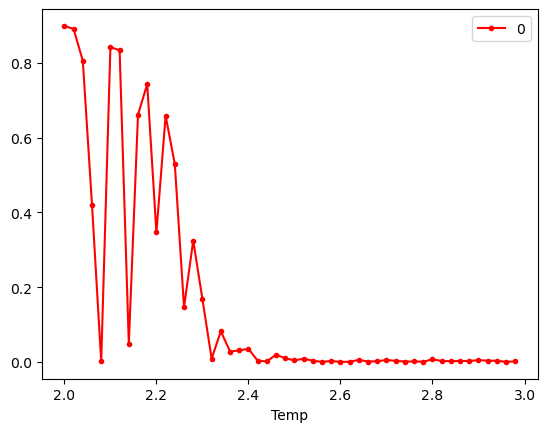

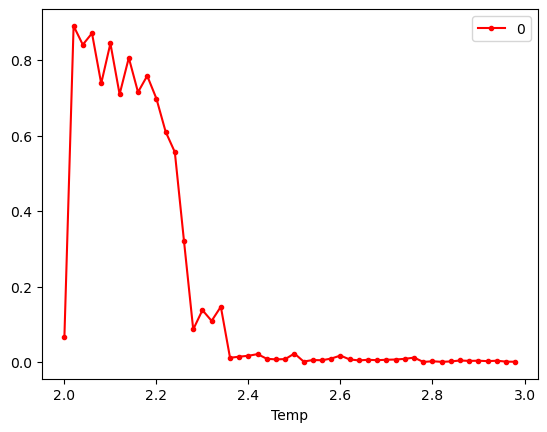

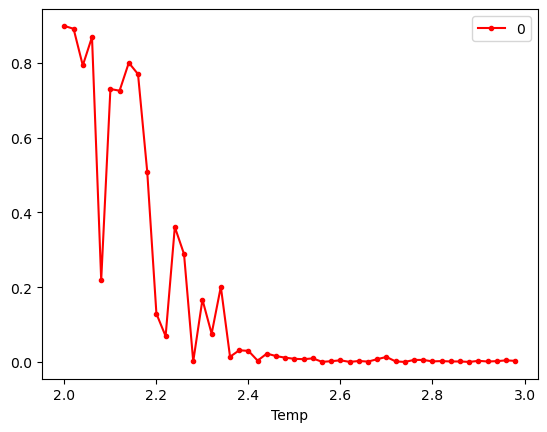

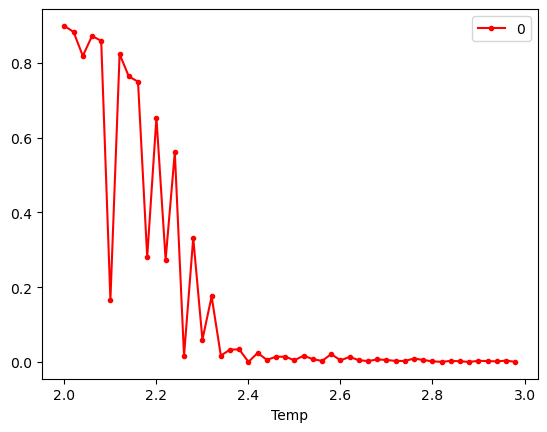

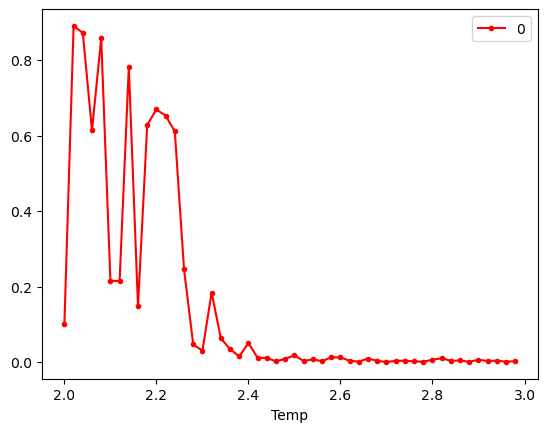

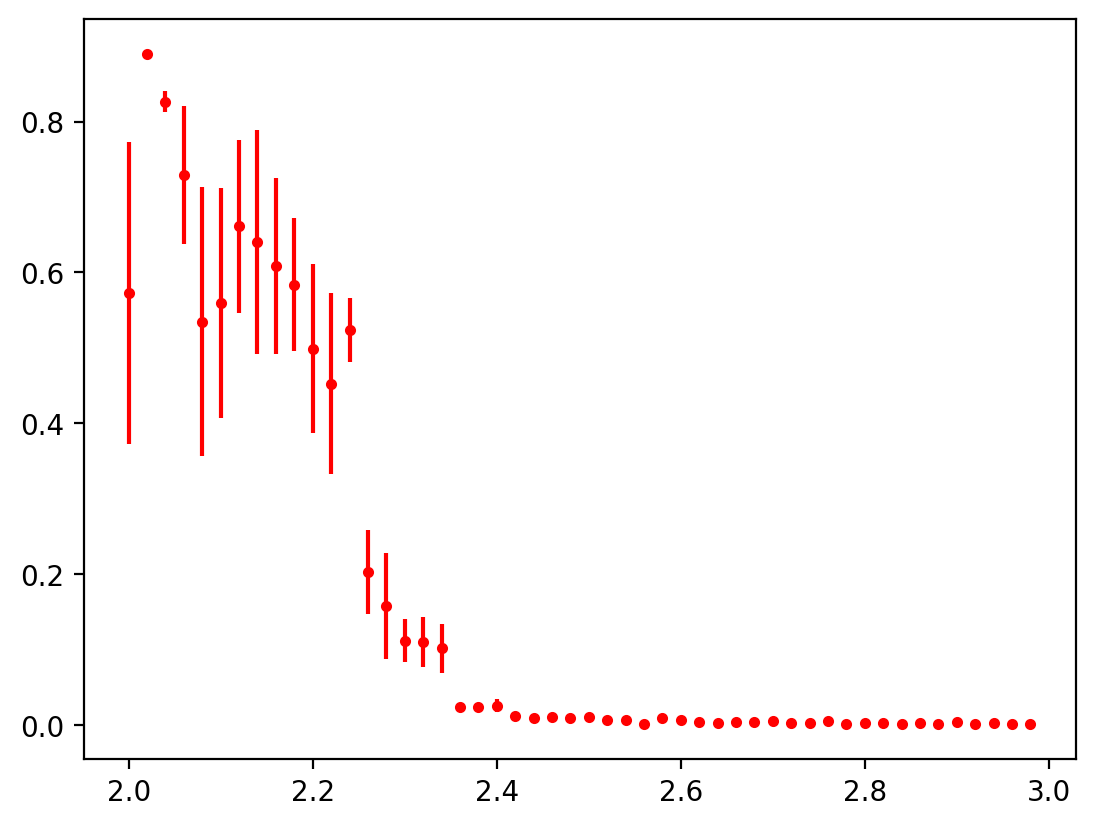

In [14]:
df_list=[]
for dir in os.listdir(os.getcwd()):
    if '20230406' not in dir:
        continue
    datadir=os.path.join(os.getcwd(),dir)
    for file in os.listdir(datadir):
        if 'EM' in file:
            df=pd.read_csv(os.path.join(datadir,file),header=2,index_col=0)
            # print(df)
            df=abs(df[['M_mean']])
            df=df.rename({'M_mean':file.replace('.csv','').split('_v')[1]},axis=1)
            df_list.append(df)
            df.plot(color='r',marker='.')
    data_df=pd.concat(df_list,axis=1)
plt.figure(dpi=200)
if len(data_df.columns)>1:
    mean=data_df.mean(axis=1)
    std=data_df.std(axis=1)
    plt.errorbar(data_df.index,mean,yerr=std/np.sqrt(len(data_df.columns)),marker='.',color='r',linestyle='none')
else:
    data_df.plot(color='r',marker='.')
plt.show()

# MONITORING PROGRESS ON GRACE

In [1]:
fname='slurm-18037105.out'
start_temp=set()
end_temp=set()
for line in open(fname).readlines():
    if 'Starting Temp' in line:
        start_temp.add(float(line.replace('/n','').split()[2].strip()))
    elif 'Finished Temp' in line:
        end_temp.add(float(line.replace('/n','').split()[2].strip()))
print('Unfinished temps:',start_temp.difference(end_temp))

Unfinished temps: {1.3, 2.94, 1.82, 4.26, 4.11}
